# Feature Selection Using RFE, Training, and Testing

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
PREPROCESSED_DATA_PATH = "../../data/preprocessed/"

## Read Data

In [3]:
train_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "train.parquet")

val_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "validation.parquet")
small_test_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "test.parquet")

test_df = pd.concat([val_df, small_test_df], axis=0)

## Split Data Into Training and Testing

In [4]:
TARGET = 'copiesSold'

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

In [5]:
pd.set_option('display.max_columns', None)
X_train.head()

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other
11655,0,0,0,-0.127185,1,0.0,2024,0.230306,-0.973118,-0.959158,-0.331901,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.129008,-0.485228,-0.422150,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
9303,0,0,0,-0.127185,1,0.0,2024,-0.060213,-0.998186,-1.631332,1.072290,0,0,0,0,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.430898,0.109341,0.140908,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
56618,0,0,0,-0.127185,1,0.0,2007,0.179767,-0.983709,-0.061180,-0.331901,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.575401,0.109341,0.301146,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
55579,1,0,0,0.105103,1,0.0,2019,-0.188227,0.982126,-1.631332,-0.331901,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.129008,0.703911,0.243282,-0.241008,7.064584,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
64439,1,0,0,-0.069113,1,0.0,2022,0.280231,-0.959933,-1.631332,1.180305,0,0,1,1,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,-0.833418,-1.079798,-0.496087,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0


In [6]:
y_train.head()

11655   -1.779482
9303    -0.239155
56618   -0.308263
55579    1.184708
64439    1.225789
Name: copiesSold, dtype: float64

## Definitions

### Models I Will Use To Feature Select and Train

In [ ]:
models = {
    # n_jobs=-1 parallelizes models to speed things up
    'LinearRegression': LinearRegression(n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42)
}

### Hyper Parameters I Will Test Per Model

In [ ]:
param_grids = {
    # Linear Regression in sklearn doesn't have the learning rate hyperparameter since it doesn't use gradient descent
    # It solves the derevative mathematically
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

### Cross Validation Used In RFE and Grid Search

In [9]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)

## Feature Selecting, Hyperparameter Tuning, Training, and Testing

In [ ]:
models_test_metrics = {}

for model_name, model in models.items():
    print(f"\nRunning RFECV for {model_name}...")

    # Feature Selection, RFECV automatically finds the best number of features
    rfecv = RFECV(
        estimator=model,
        step=5,
        cv=cv,
        scoring='r2',
        n_jobs=-1
    )
    rfecv.fit(X_train, y_train)

    selected_features = X_train.columns[rfecv.support_]
    print(f"Selected {len(selected_features)} features for {model_name}.")
    print(f"Selected features: {list(selected_features)}")

    # Filter X to only have the selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    print(f"\nRunning GridSearchCV for {model_name}...")

    # Hyperparameter tuning and Training using Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=cv,
        scoring='r2',
        n_jobs=-1
    )
    grid_search.fit(X_train_selected, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Choose the trained model with the best hyperparameters
    best_model = grid_search.best_estimator_

    # Predict using the choosen model
    test_preds = best_model.predict(X_test_selected)

    # Calculate error metrics
    mse = mean_squared_error(y_test, test_preds)
    mae = mean_absolute_error(y_test, test_preds)
    r2 = r2_score(y_test, test_preds)

    models_test_metrics[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}


Running RFECV for LinearRegression...
Selected 50 features for LinearRegression.
Selected features: ['steam_achievements', 'steam_trading_cards', 'workshop_support', 'achievements_total', 'is_release_date_known', 'is_upcoming', 'year', 'sin_day', 'cos_day', 'price', 'reviewScore', 'has_demo', 'demo_count', 'has_dlc', 'dlc_count', 'metacritic_preprocessed', 'has_metacritic', 'genre_Action', 'genre_Adventure', 'genre_Casual', 'genre_Early Access', 'genre_Free To Play', 'genre_Gore', 'genre_Indie', 'genre_Massively Multiplayer', 'genre_Nudity', 'genre_Other', 'genre_RPG', 'genre_Racing', 'genre_Sexual Content', 'genre_Simulation', 'genre_Sports', 'genre_Strategy', 'genre_Violent', 'platform_linux', 'platform_mac', 'platform_windows', 'name_len', 'name_words', 'name_cap_ratio', 'is_sequel', 'name_has_vr', 'name_has_remaster', 'name_has_collector', 'name_has_collection', 'name_has_edition', 'name_has_bundle', 'name_has_playtest', 'publisherClass_Indie', 'publisherClass_Other']

Running Gri

[0.4808, 0.2816]


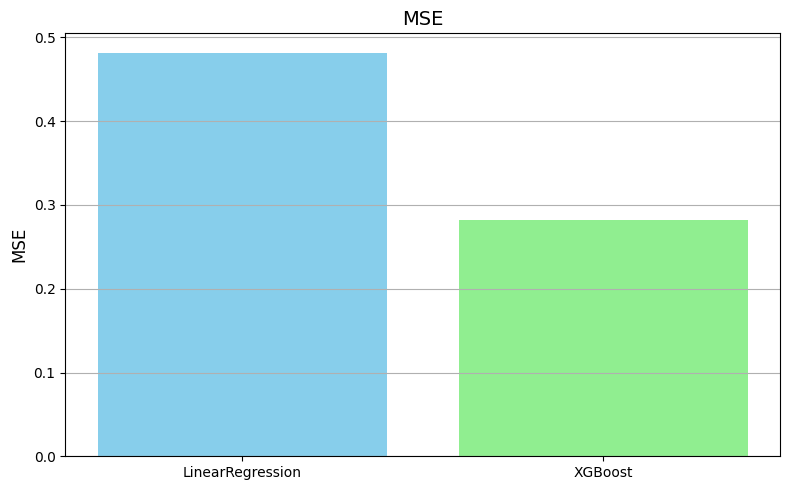

[0.5442, 0.41]


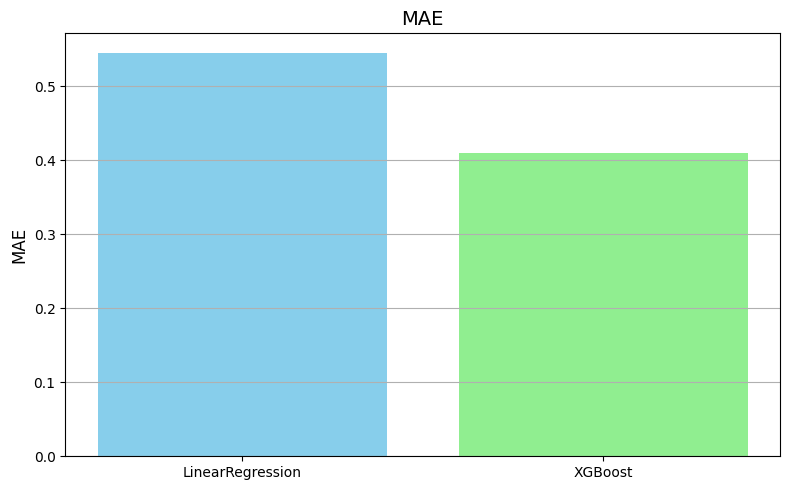

[0.5216, 0.7198]


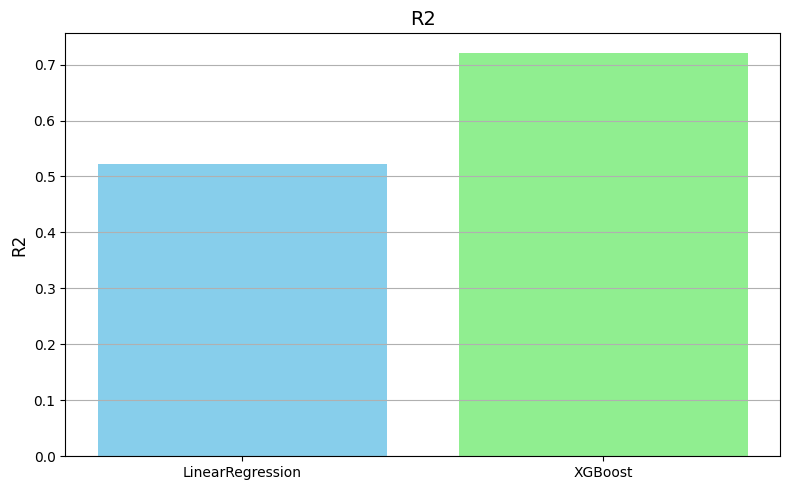

In [16]:
metrics = ['MSE', 'MAE', 'R2']

for metric in metrics:
    values = [models_test_metrics[model][metric] for model in models.keys()]

    rounded_values = [round(value, 4) for value in values]
    print(rounded_values)

    plt.figure(figsize=(8, 5))
    plt.bar(models.keys(), values, color=['skyblue', 'lightgreen'])
    plt.title(f'{metric}', fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()